In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
import VFDstuff as VFD
from pint import UnitRegistry; AssignQuantity = UnitRegistry().Quantity
from copy import copy as cp
import matplotlib.path as mpltPath

In [2]:
%matplotlib notebook
fontsize = 14
color = 'k'
linewidth = 4
markersize = 10
margin = 0.2

# Units
distance_unit = 'micrometer'
pressure_unit = 'pascal'
time_unit = 'microsecond'
angle_unit = 'radian'

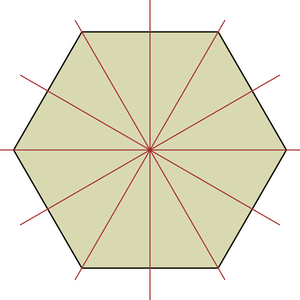

In [3]:
# Defining properties of the crystal and the box it's in

# Some key parameters
L = AssignQuantity(30,distance_unit)
npts_theta = 8
npts_r = 25
r_far_field = L*1.2

In [4]:
if np.mod(npts_theta,2) != 0:
    npts_theta += 1
itheta_middle = np.rint(npts_theta/2).astype('int'); #print(itheta_middle)
left_partner = [True]
for itheta in range(1,itheta_middle+1):
    left_partner.append(False)
for itheta in range(itheta_middle+2,npts_theta+1):
    left_partner.append(True)
left_partner = left_partner * 6; 

right_partner = []
for itheta in range(itheta_middle):
    right_partner.append(True)
for itheta in range(itheta_middle+1,npts_theta+1):
    right_partner.append(False)
right_partner = right_partner * 6

# print('\n left partners:')
# for i in range(len(left_partner)):
#     if np.mod(i,npts_theta) == 0:
#         print('')
#     print(i,left_partner[i])

# print('\n right partners:')
# for i in range(len(right_partner)):
#     if np.mod(i,npts_theta) == 0:
#         print('')
#     print(i,right_partner[i])


<IPython.core.display.Javascript object>


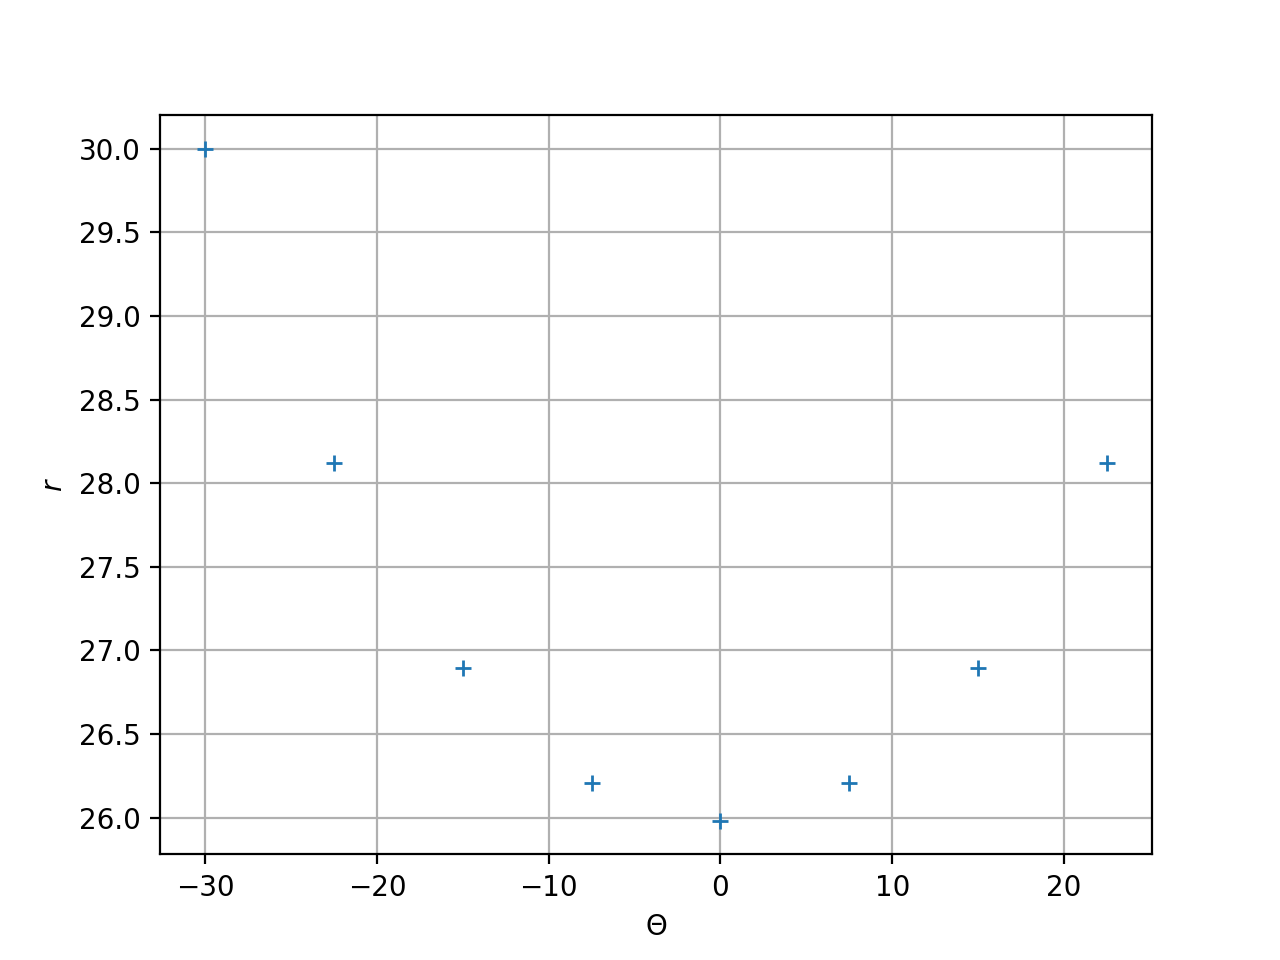

/Users/erinthill/anaconda3/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1340: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return np.asarray(x, float)


<IPython.core.display.Javascript object>


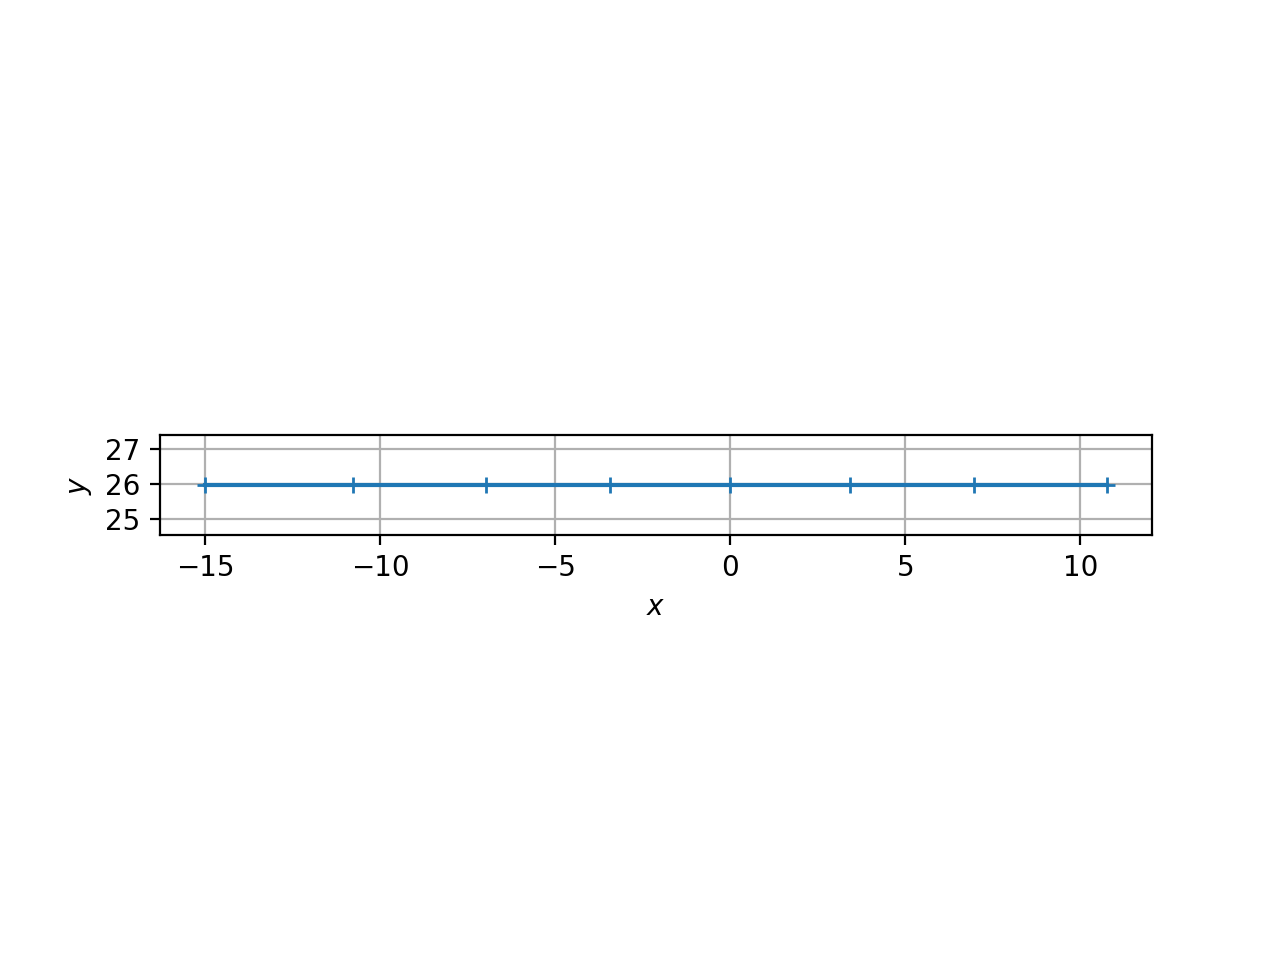

<IPython.core.display.Javascript object>


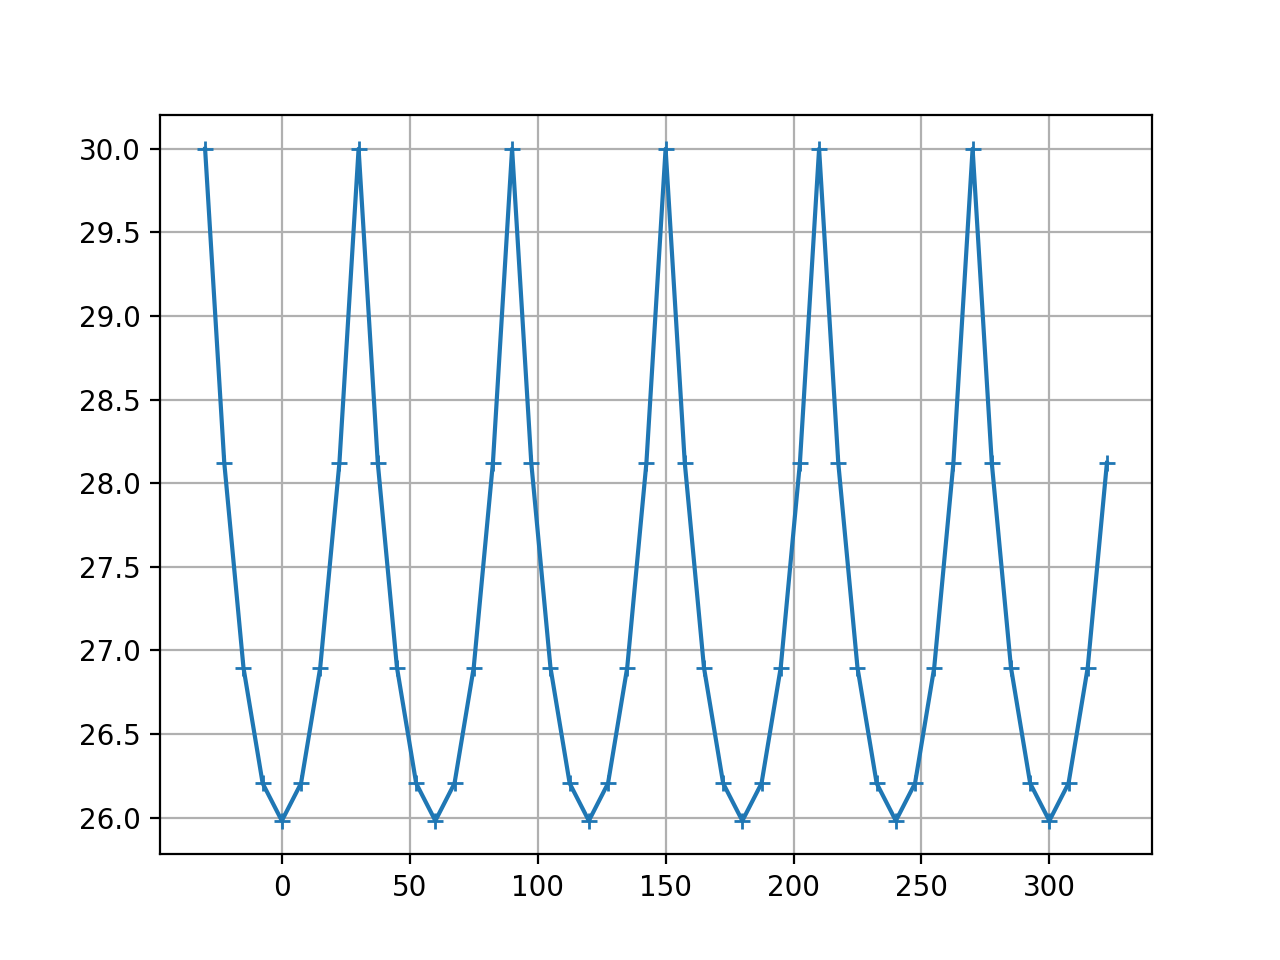

(48,)
(48,)


In [5]:
# Making the crystal

# Make the top edge of the crystal
angle = AssignQuantity(30, 'degree')
angle.ito(angle_unit)
y0 =L*np.cos(angle)
edge0_theta_complete = np.linspace(-angle,angle,npts_theta+1)
edge0_theta = edge0_theta_complete[0:-1]
dtheta = edge0_theta[1]-edge0_theta[0]
edge0_r = y0/np.cos(edge0_theta)
fig, ax = plt.subplots()
plt.plot(edge0_theta.to('degree'),edge0_r,'+')
plt.xlabel('$\Theta$')
plt.ylabel('$r$')
plt.grid(True)

# Convert to Cartesian to make sure this is a straight line at the right place
edge0_x = edge0_r*np.sin(edge0_theta)
edge0_y = edge0_r*np.cos(edge0_theta)
fig, ax = plt.subplots()
ax.set_aspect('equal')
plt.plot(edge0_x,edge0_y,'+-')
plt.grid(True)
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.grid(True)

# Gather all the edges together as one big array
edges_theta = np.hstack([\
        edge0_theta,
        edge0_theta+2*angle,
        edge0_theta+4*angle,
        edge0_theta+6*angle,
        edge0_theta+8*angle,
        edge0_theta+10*angle])
edges_r = np.hstack([\
        edge0_r,
        edge0_r,
        edge0_r,
        edge0_r,
        edge0_r,
        edge0_r])
edges_r = AssignQuantity(edges_r,distance_unit)
edges_theta = AssignQuantity(edges_theta,angle_unit)
fig, ax = plt.subplots()
print(np.shape(edges_theta.to('degree').magnitude))
print(np.shape(edges_r.magnitude))
plt.plot(edges_theta.to('degree').magnitude,edges_r.magnitude,'+-')
plt.grid(True)
npts_edge = len(edges_r)

36.0 micrometer
dr = 0.4174682452694505 micrometer


<IPython.core.display.Javascript object>


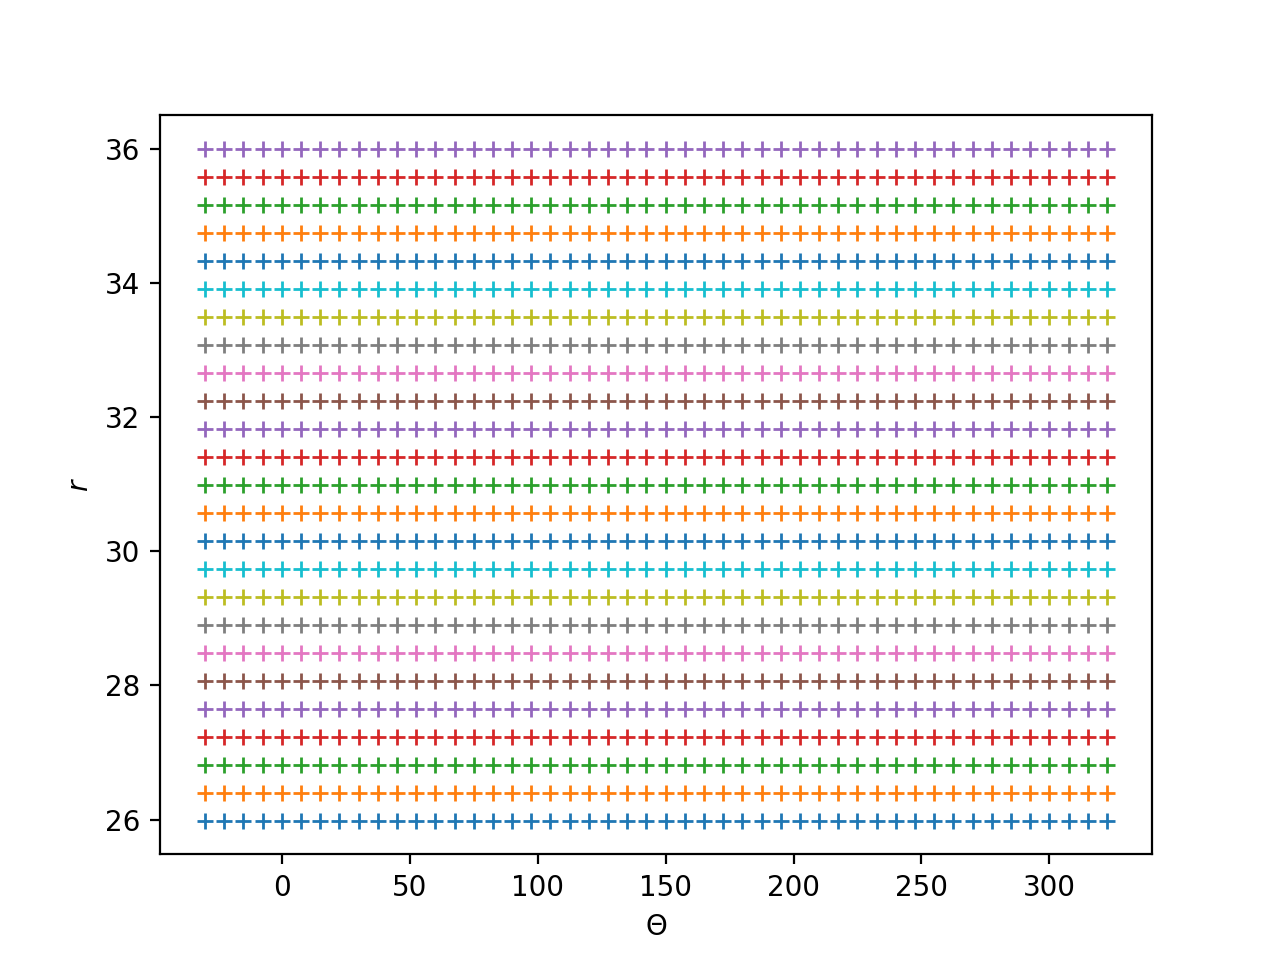

(48, 25)
(48, 25)


<IPython.core.display.Javascript object>


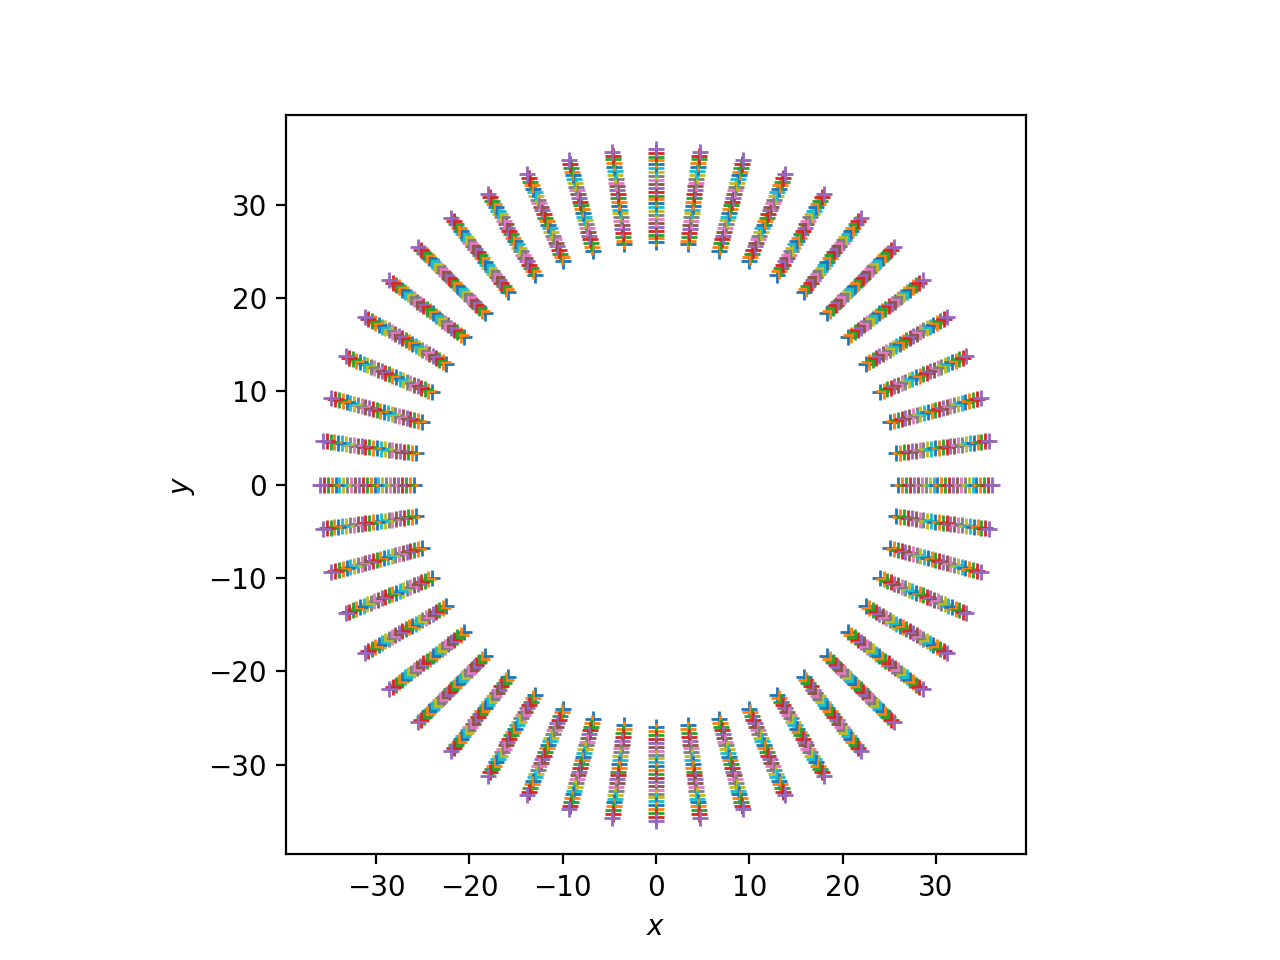

Text(0, 0.5, '$y$')

In [6]:
# Making a discretized box to put the crystal into (we'll use the crystal's angles)
rmin = np.min(edges_r); #print(rmin)
rmax = r_far_field; print(rmax)
array_r = np.linspace(rmin,rmax,npts_r)
dr = array_r[1]-array_r[0]; print('dr =', dr)
array_theta = edges_theta
grid_r, grid_theta = np.meshgrid(array_r.magnitude,array_theta.magnitude)
grid_r = AssignQuantity(grid_r,distance_unit)
grid_theta = AssignQuantity(grid_theta,angle_unit)
plt.figure()
plt.plot(grid_theta.to('degree').magnitude,grid_r.magnitude,'+')
plt.xlabel('$\Theta$')
plt.ylabel('$r$')

# Converting to Cartesian to see what this looks like
grid_x = grid_r*np.sin(grid_theta); print(np.shape(grid_x))
grid_y = grid_r*np.cos(grid_theta); print(np.shape(grid_y))
fig, ax = plt.subplots()
ax.set_aspect('equal')
plt.plot(grid_x.magnitude,grid_y.magnitude,'+')
plt.xlabel('$x$')
plt.ylabel('$y$')

In [7]:
# Physical parameters

# Setting ice parameters
sigma0 = 0.2
print('sigma0 = ',sigma0)

# The far-field supersaturation
sigmaI_far_field = 0.25

# Temperature and pressure
Temp = AssignQuantity(240,'kelvin')
Pressure = AssignQuantity(50,'pascal')

# Converting to the desired pressure unit
Pressure.ito(pressure_unit)
print('Pressure = ', Pressure)
print('Temperature = ',Temp)

# Checking on the plausibility of this growth rate
nu_kin = VFD.get_nu_kin(Temp,AssignQuantity)
print('g_ice should be smaller than sigmaI_far_field x nu_kin ...')
print('nu_kin = ', nu_kin)
print('sigmaI_far_field x nu_kin = ', sigmaI_far_field*nu_kin)

# Compute diffusion coefficient of water through air at this temperature
# This is using trends from engineering toolbox, with the log-log correction
D = VFD.getDofTP(Temp,Pressure,AssignQuantity); print('D = ', D)

# Growth rate
g_ice = AssignQuantity(2,'micrometer/second')
print('g_ice',g_ice)

# Calculating the Neumann condition at the vapor/ice boundary (starting with ice density)
rho_ice = AssignQuantity(0.9,'g/cm^3')
Mvap = AssignQuantity(18,'g/mol')
R = AssignQuantity(8.314,'J/mol/kelvin')

sigma0 =  0.2
Pressure =  50 pascal
Temperature =  240 kelvin
g_ice should be smaller than sigmaI_far_field x nu_kin ...
nu_kin =  39.341788071548116 micrometer / second
sigmaI_far_field x nu_kin =  9.835447017887029 micrometer / second
D0 =  21.893732126411837
D =  34908.31943863489 micrometer ** 2 / microsecond
g_ice 2 micrometer / second


In [8]:
# Time step, boundary conditions, etc.

# Getting a suitable time step
dt = dr**2/D/3; print('dt = ', dt)

# Computing effective diffusion coefficents - which should be dimensionless
D_times_dt = D*dt; print('D_times_dt = ', D_times_dt)
Dreff1 = (D_times_dt / dr)
Dreff2 = (D_times_dt / dr**2)
Dteff2 = (D_times_dt / dtheta**2)

# kappa (need to check if this is right)
kappa = rho_ice*g_ice*R*Temp/(Mvap*dr); kappa.ito(pressure_unit+'/'+time_unit)
print('kappa',kappa)

# Neumann
uneumann = kappa*dt; print('uneumann',uneumann)
uneumann_mag = uneumann.magnitude

# Calculating the dirichlet conditions at the far-field boundary
sigmaII_far_field = sigmaI_far_field - sigma0
print('sigmaI_far_field = ', sigmaI_far_field)
print('sigmaII_far_field = ', sigmaII_far_field)

# Converting this into pressures
P3 = AssignQuantity(611,'Pa')
T3 = AssignQuantity(273,'kelvin')
Delta_H_sub = AssignQuantity(50,'kJ/mol')
P_vapor_eq = P3*np.exp(-Delta_H_sub/R*(1/Temp-1/T3)); print('Equilibrium vapor pressure at this temperature = ', P_vapor_eq)
udirichlet = P_vapor_eq*(sigmaI_far_field+1)
print('udirichlet = ', udirichlet)

# Making dimensionless variables for efficiency
udirichlet_mag = udirichlet.magnitude

dt =  1.6641661988791267e-06 microsecond
D_times_dt =  0.05809324526945136 micrometer ** 2
kappa 477.96689271829905 pascal / microsecond
uneumann 0.000795416347045079 pascal
sigmaI_far_field =  0.25
sigmaII_far_field =  0.04999999999999999
Equilibrium vapor pressure at this temperature =  29.55023347583504 pascal
udirichlet =  36.9377918447938 pascal


In [9]:
# Index <--> position interconversion functions

def r_to_ir(r,array_r):
    dr = array_r[1]-array_r[0]
    ir = np.rint((r-array_r[0])/dr).astype(int)
    return ir
r_test = AssignQuantity(107, distance_unit)
ir_test = r_to_ir(r_test, array_r)
print(ir_test)

def ir_to_r(ir_test,array_r):
    dr = array_r[1]-array_r[0]
    r = ir_test*dr+array_r[0]
    return r
r_test2 = ir_to_r(ir_test, array_r)
print('r_test2', r_test2)
print('r Differences ... ', r_test2-r_test)

def theta_to_itheta(theta, array_theta):
    dtheta = array_theta[1]-array_theta[0]
    itheta = np.rint((theta-array_theta[0])/dtheta).astype(int)
    return itheta
theta_test = AssignQuantity(-32, 'degree')
itheta_test = theta_to_itheta(theta_test.to(angle_unit), array_theta)
print(itheta_test)

def itheta_to_theta(itheta, array_theta):
    dtheta = array_theta[1]-array_theta[0]
    theta = itheta*dtheta+array_theta[0]
    return(theta)
theta_test2 = itheta_to_theta(itheta_test, array_theta)
print('theta_test2', theta_test2)
print('theta Differences ... ', theta_test2-theta_test)

194 dimensionless
r_test2 106.96960169580655 micrometer
r Differences ...  -0.03039830419345435 micrometer
0 dimensionless
theta_test2 -0.5235987755982988 radian
theta Differences ...  0.03490658503988664 radian


10 dimensionless


<IPython.core.display.Javascript object>


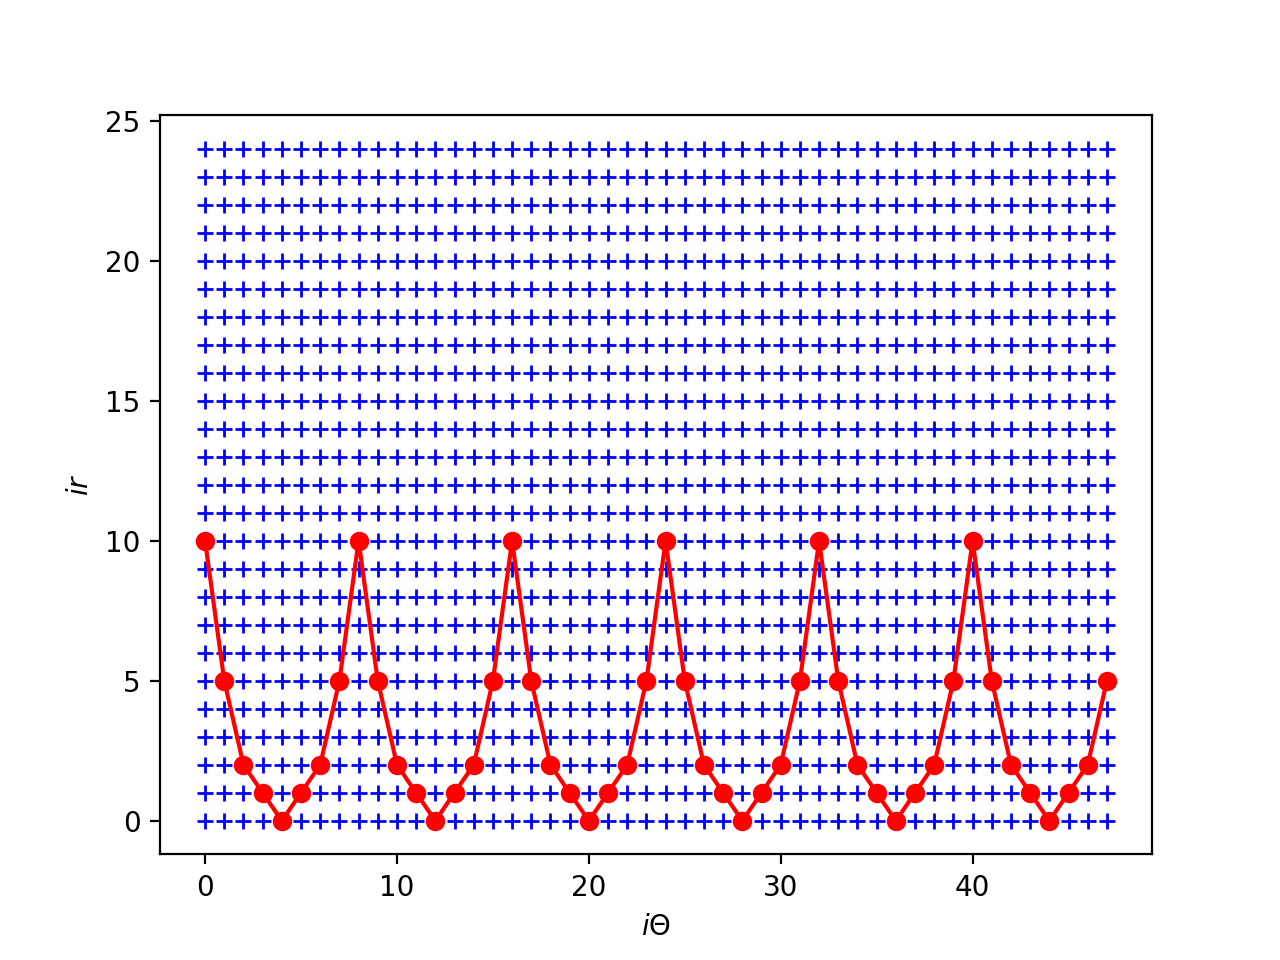

<IPython.core.display.Javascript object>


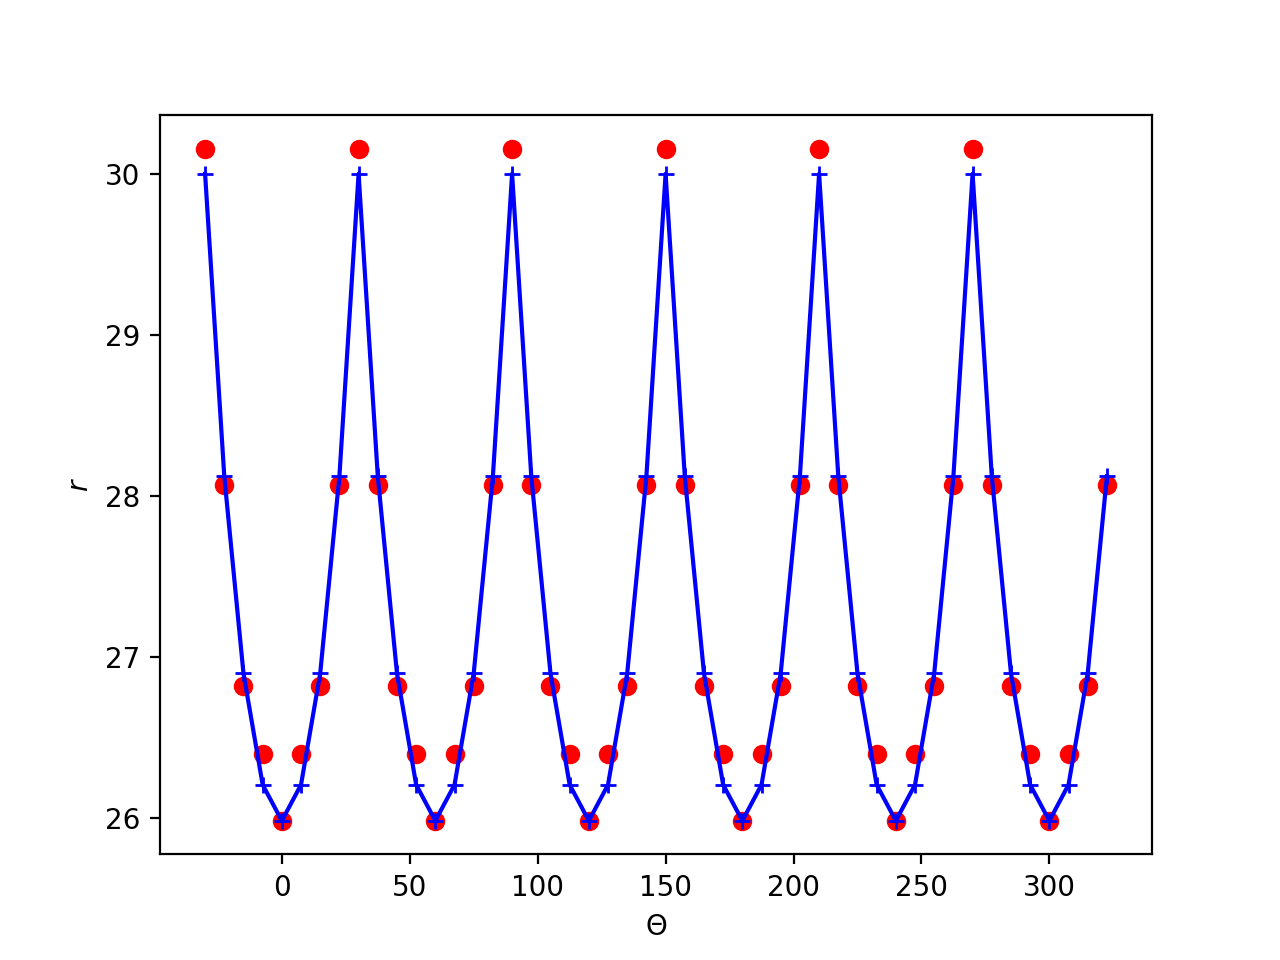

Text(0, 0.5, '$r$')

In [10]:
# Plotting the crystal edge in index space
edges_ir = r_to_ir(edges_r,array_r)
edges_itheta = theta_to_itheta(edges_theta, array_theta)
edges_ir_max = np.max(edges_ir); print(edges_ir_max)

igrid_r = r_to_ir(grid_r,array_r)
igrid_theta = theta_to_itheta(grid_theta, array_theta)

plt.figure()
plt.plot(igrid_theta,igrid_r,'+b')
plt.plot(edges_itheta.magnitude,edges_ir.magnitude,'ro-')
plt.xlabel('$i\Theta$')
plt.ylabel('$ir$')

edges_r2 = ir_to_r(edges_ir, array_r)
edges_theta2 = itheta_to_theta(edges_itheta, array_theta)

plt.figure()
plt.plot(edges_theta2.to('degree'),edges_r2,'ro')
plt.plot(edges_theta.to('degree').magnitude,edges_r.magnitude,'b+-')
plt.xlabel('$\Theta$')
plt.ylabel('$r$')

### Progress
The cells below are "in progress"

In [11]:
def Polar_propagate_hexagon(u0, udirichlet, uneumann, \
                            Dreff1, Dreff2, Dteff2, \
                            edges_r, edges_ir, \
                            array_r, left_partner, right_partner):

    # Propagates the vapor field forward one time step
    
    # Initialize starting values (all should be overwritten)
    un = np.ones(np.shape(u0))
    un_angular_diffusion = np.ones(np.shape(u0))

    # Previous plus diffusion in r
    npts_edge = len(edges_r)
    for itheta in range(npts_edge):
        
        # Radial indices for the surface-adjacent layer (ir) and two farther out
        ir = edges_ir[itheta]
        ir_plus1 = ir+1
        ir_plus2 = ir+2
                
        # Radial diffusion one layer above the surface-adjacent layer, out to the far field
        un[itheta,ir_plus1:-1] = u0[itheta,ir_plus1:-1] +\
            (u0[itheta,ir_plus2:] - 2*u0[itheta,ir_plus1:-1] +u0[itheta,ir:-2])*Dreff2 +\
            (u0[itheta,ir_plus2:]   - u0[itheta,ir_plus1:-1])                  *Dreff1/array_r[ir_plus1:-1]
        
        # Radial diffusion for the surface-adjacent layer 
        un[itheta,ir] = u0[itheta,ir] +\
            (u0[itheta,ir_plus1] - u0[itheta,ir])*Dreff2 +\
            (u0[itheta,ir_plus1] - u0[itheta,ir])*Dreff1/array_r[ir]
        
    # Assigning Dirichlet conditions at the far-field limit
    un[:,-1] = udirichlet
    
    # Assigning Neumann conditions at the surface-adjacent layer
    for itheta in range(npts_edge):
        
        # Radial index for the surface-adjacent layer (ir)
        ir = edges_ir[itheta]
        un[itheta,ir] -= uneumann *edges_r[0]/edges_r[itheta]
            
    # Diffusion in theta
    for itheta in range(npts_edge):

        # Radial index for the surface-adjacent layer (ir)
        ir = edges_ir[itheta]

        # Prep for angular diffusion: nearby theta indices, periodic boundary indices
        itheta_minus1 = itheta-1
        itheta_plus1 = itheta+1
        if itheta_plus1 == npts_edge:
            itheta_plus1 = 0        
        
        # Assume two-directional angular diffusion at all r-values (some will be overwritten)
        un_angular_diffusion[itheta,:] = \
            (u0[itheta_minus1,:] -2*u0[itheta,:] +u0[itheta_plus1,:] ) *Dteff2/array_r**2
        
        # Zero out in-crystal diffusion
        un_angular_diffusion[itheta,0:ir] = 0
        
        # Find the nearest angular neighbor that is higher than this one 
        if left_partner[itheta] == False and right_partner[itheta] == True: # Sloping down, or 1st of several bottom pixels 
            ir_up = edges_ir[itheta_minus1]
            un_angular_diffusion[itheta,ir:ir_up] = (u0[itheta_plus1,ir:ir_up] - u0[itheta,ir:ir_up]) \
                *Dteff2/array_r[ir:ir_up]**2
        if left_partner[itheta] == True and right_partner[itheta] == False: # Sloping up, or last of several bottom pixels 
            ir_up = edges_ir[itheta_plus1]
            un_angular_diffusion[itheta,ir:ir_up] = (u0[itheta_minus1,ir:ir_up] - u0[itheta,ir:ir_up]) \
                *Dteff2/array_r[ir:ir_up]**2
        elif left_partner[itheta] == False and right_partner[itheta] == False: # Solitary bottom pixel
            un_angular_diffusion[itheta,ir] = 0

    # Zeroing out the crystal values
    for itheta in range(npts_edge):
        ir = edges_ir[itheta]
        un[itheta,0:ir] = 0
            
    # Add in the diffusion
    un += un_angular_diffusion

    return(un,un_angular_diffusion)

In [12]:
# Decide on a time to propagate forward
tmax = AssignQuantity(.01,time_unit)
ntimes = int(tmax/dt)
print('Integrating steps = ', ntimes)
print('Integrating out to ', ntimes*dt) # This is a check -- it should be very close to the tmax specified above
print('g_ice =',g_ice)

# Propagate forward in time
un = np.ones(np.shape(igrid_r))*udirichlet.magnitude
for i in range(ntimes):
    un,un_angular_diffusion = Polar_propagate_hexagon(\
        un, udirichlet.magnitude, uneumann.magnitude, \
        Dreff1.magnitude, Dreff2.magnitude, Dteff2.magnitude/1, \
        edges_r.magnitude, edges_ir.magnitude, \
        array_r.magnitude, left_partner, right_partner)

Integrating steps =  6009
Integrating out to  0.009999974689064672 microsecond
g_ice = 2 micrometer / second


0
10


<IPython.core.display.Javascript object>


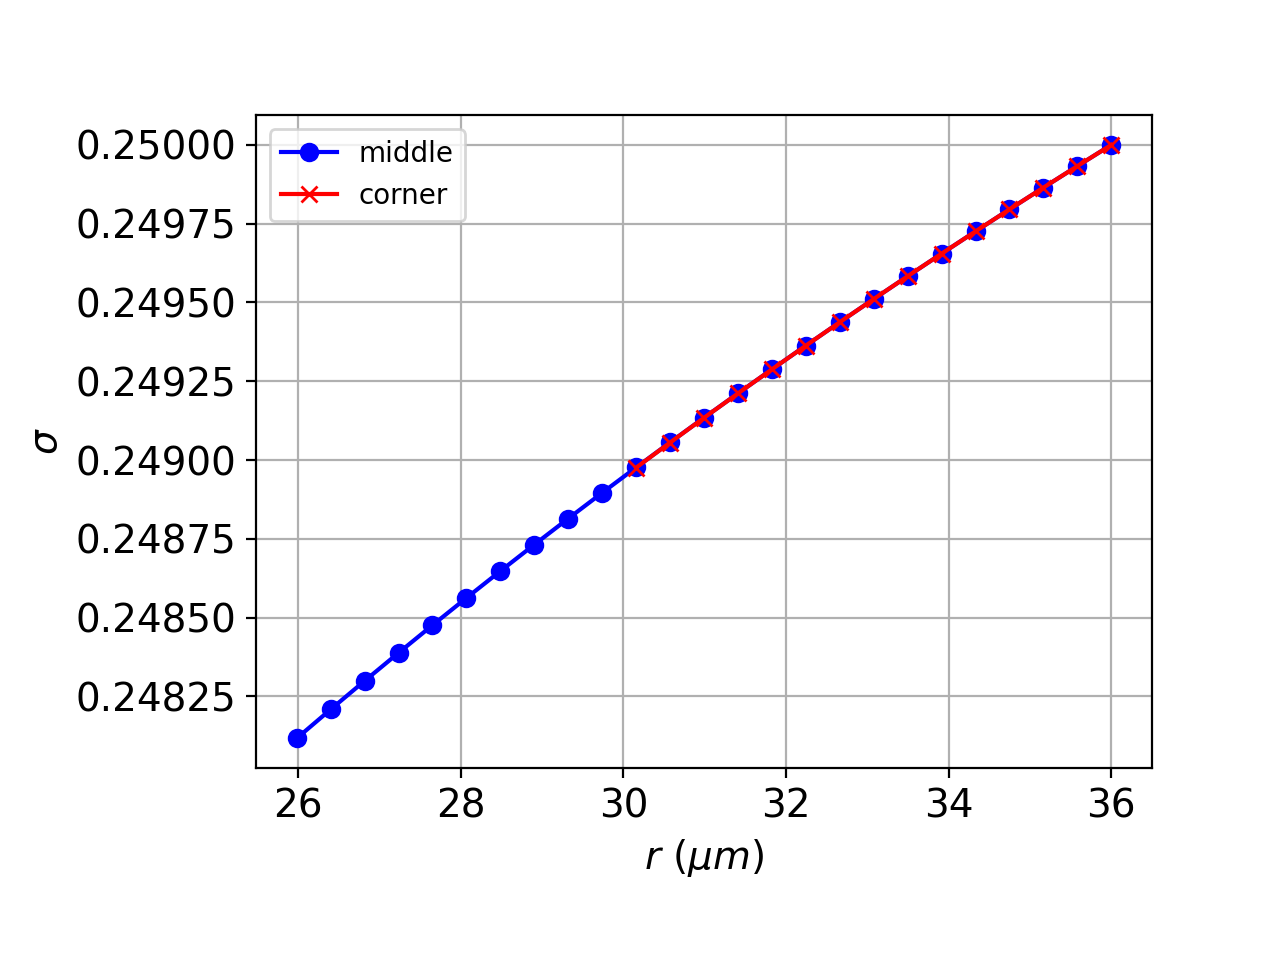

<IPython.core.display.Javascript object>


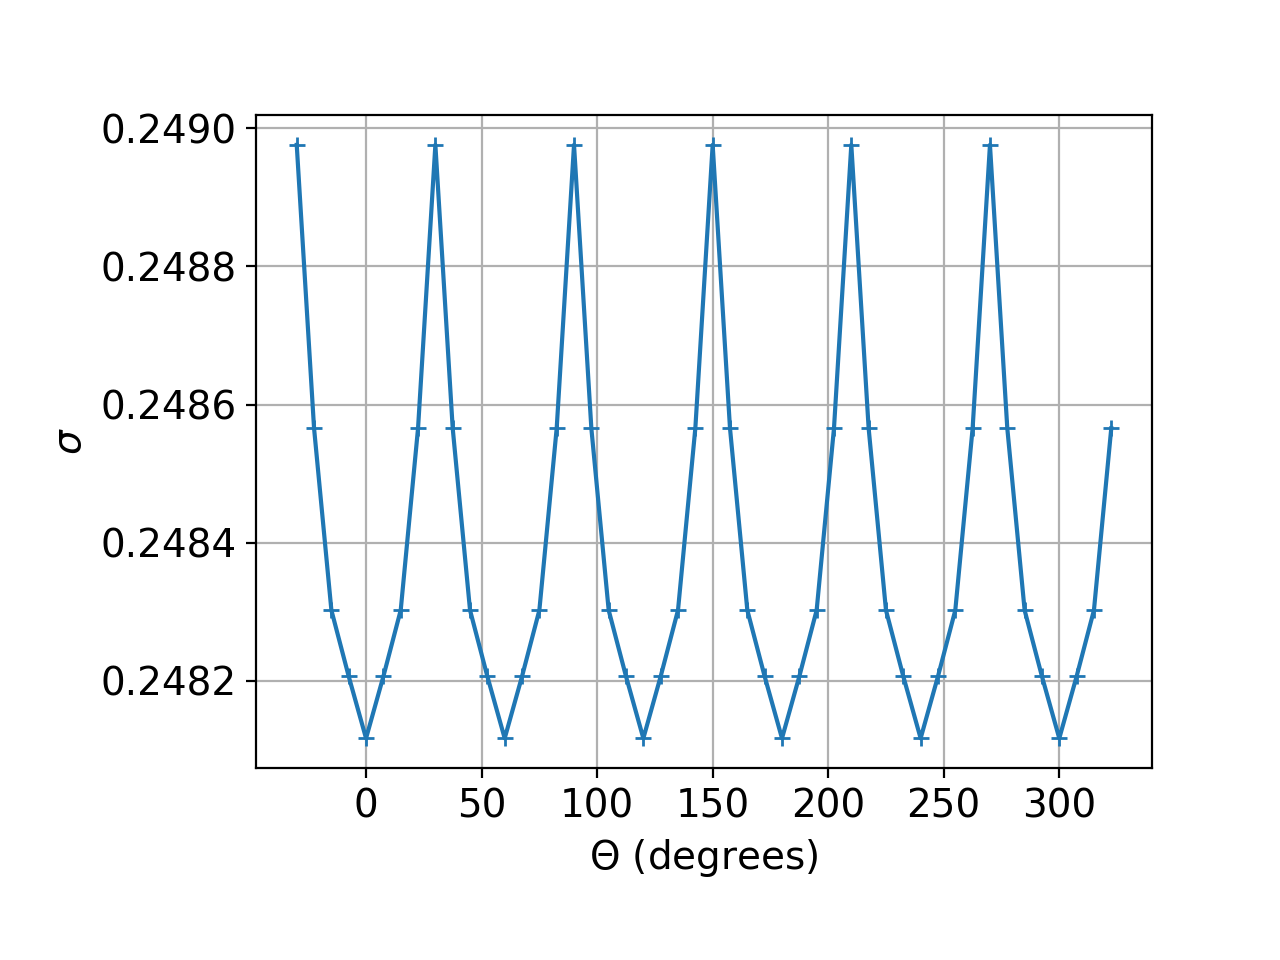

sigma1 0.24811687947893524
sigma2 0.25


<IPython.core.display.Javascript object>


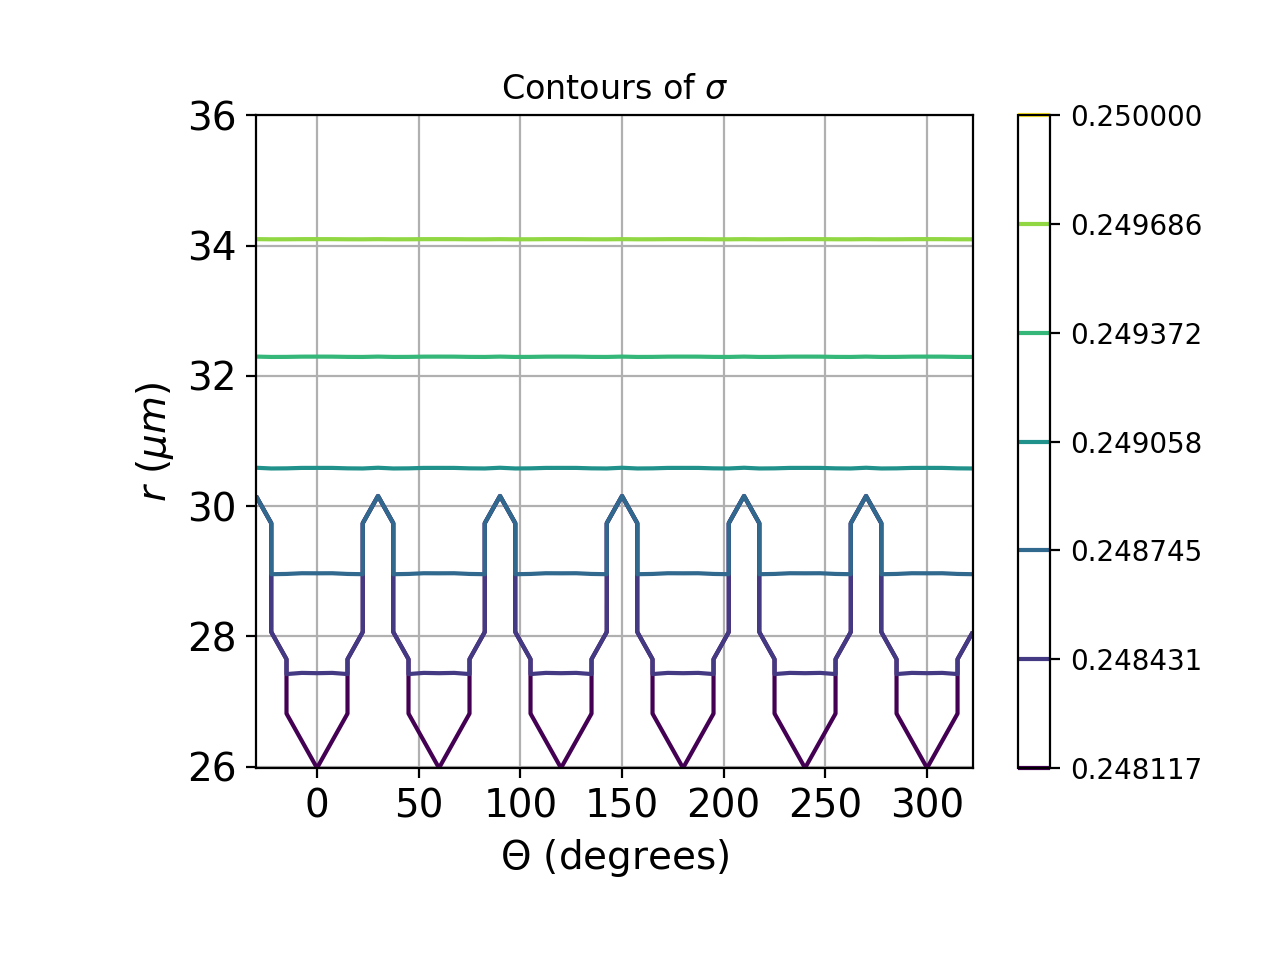

In [13]:
# Graphic investigation of the results

# As a function of r (starting at the adjacent surface, for an angle in the middle of the 1st facet)
ir_middle = edges_ir[itheta_middle].magnitude; print(ir_middle)
sigma_radial_middle = (un[itheta_middle,ir_middle:]/P_vapor_eq.magnitude-1)
ir_0 = edges_ir[0].magnitude; print(ir_0)
sigma_radial_0 = (un[0,ir_0:]/P_vapor_eq.magnitude-1)
plt.figure()
plt.plot(array_r[ir_middle:],sigma_radial_middle,'o-b',label='middle')
plt.plot(array_r[ir_0:],sigma_radial_0,'x-r',label='corner')
plt.xlabel('$r$ ($\mu m$)', fontsize=fontsize)
plt.subplots_adjust(bottom=margin) 
plt.subplots_adjust(left=margin) 
plt.ylabel('$\sigma$', fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.grid(True)
# plt.ylim([0,sigmaI_far_field*101])
plt.legend()

# As a function of angle at the adjacent surface (ir)
sigma_edge = np.zeros(npts_edge)
for itheta in range(npts_edge):
    ir = edges_ir[itheta].magnitude
    sigma_edge[itheta] = (un[itheta,ir]/P_vapor_eq.magnitude-1)
plt.figure()
plt.plot(array_theta.to('degree').magnitude,sigma_edge,'+-')
plt.xlabel('$\Theta$ (degrees)', fontsize=fontsize)
plt.ylabel('$\sigma$', fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.subplots_adjust(bottom=margin) 
plt.subplots_adjust(left=margin) 
plt.grid(True)

# As a contour plot in {theta,r} space
sigma_grid = (un/P_vapor_eq.magnitude-1)
sigma1 = sigma_grid[itheta_middle,ir_middle]; print('sigma1',sigma1)
sigma2 = sigmaI_far_field; print('sigma2',sigma2)
nlevels = 7
levels = np.linspace(sigma1,sigma2,nlevels)
fig,ax = plt.subplots()
CS = ax.contour(array_theta.to('degree').magnitude,array_r.magnitude,sigma_grid.T,levels)
ax.set_xlabel('$\Theta$ (degrees)', fontsize=fontsize)
ax.set_ylabel('$r$ ($\mu m$)', fontsize=fontsize)
ax.set_title('Contours of $\sigma$')
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.subplots_adjust(bottom=margin)
plt.subplots_adjust(left=margin)
plt.grid(True)
fig.colorbar(CS)

In [14]:
# The center reduction
c_r = (un[0,ir_0] - un[itheta_middle,ir_middle])/un[0,ir_0]
print('c_r ($) =', c_r*100)

c_r ($) = 0.06877196548206795
